In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import lagrange
from scipy.optimize import root_scalar
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
try:
    import sklearn_extra
except ImportError:
    !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from skimage import io, img_as_float64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.0 MB/s eta 0:00:0000:01


In [2]:
def _norm(X, eps=1e-9):
    return (X - X.min(0)) / (X.max(0) - X.min(0) + eps)

In [3]:
def _delta_block(X_norm, beta=1.0, eps=1e-8):
    n = len(X_norm)
    ratio = np.min(X_norm, 1) / (X_norm.sum(1) + eps)
    return 0.5 * ratio.sum() / n * beta

In [4]:
def _delta_block_max(X_norm, beta=1.0, eps=1e-8):
    n = len(X_norm)
    ratio = np.max(X_norm, 1) / (X_norm.sum(1) + eps)
    return 0.5 * ratio.sum() / n * beta

In [5]:
def _delta_block_half(X_norm, beta=1.0, eps=1e-8):
    n = len(X_norm)
    ratio = np.min(X_norm, 1) / (X_norm.sum(1) + eps)
    return ratio.sum() / n * beta  # No 0.5 factor

In [6]:
def _mountain_potential(Xn, delta, clip=50.0):
    dist2 = cdist(Xn, Xn, "sqeuclidean")
    return np.exp(-np.clip(dist2 / (delta**2 + 1e-12), 0, clip)).sum(1)

In [7]:
# Fuzzy C-Means (FCM)
def fcm_clustering(X, n_clusters, m=2.0, max_iter=150, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape

    U = np.random.rand(n_samples, n_clusters)
    U = U / U.sum(axis=1, keepdims=True)

    centers = np.zeros((n_clusters, n_features))

    for iteration in range(max_iter):
        Um = U ** m
        centers = (Um.T @ X) / Um.sum(axis=0, keepdims=True).T
        distances = cdist(X, centers, metric='euclidean')
        distances = np.fmax(distances, np.finfo(np.float64).eps)

        U_new = np.zeros_like(U)
        for i in range(n_samples):
            for j in range(n_clusters):
                sum_term = np.sum((distances[i, j] / distances[i, :]) ** (2 / (m - 1)))
                U_new[i, j] = 1.0 / sum_term

        if np.linalg.norm(U_new - U) < tol:
            break
        U = U_new

    labels = np.argmax(U, axis=1)

    return labels, centers, U

In [8]:
# EM Clustering
def em_clustering(X, n_clusters, max_iter=100, tol=1e-3, random_state=42):
    gm = GaussianMixture(
        n_components=n_clusters,
        max_iter=max_iter,
        tol=tol,
        random_state=random_state
    )

    labels = gm.fit_predict(X)
    centers = gm.means_

    return labels, centers

In [9]:
# K-Medoid
def k_medoid_clustering(X, n_clusters, max_iter=300, random_state=42):
    kmedoids = KMedoids(
        n_clusters=n_clusters,
        max_iter=max_iter,
        random_state=random_state
    )

    labels = kmedoids.fit_predict(X)
    centers = kmedoids.cluster_centers_

    return labels, centers

In [10]:
# IMC-1, IMC-2
def IMC1_robust(X, Nc, eps=1e-8, exp_clip=50.0):
    U = _norm(X, eps)
    n, k = U.shape
    idx = -np.ones(n, int)
    centres, delta, m = [], [], []
    remaining = np.arange(n)

    for _ in range(Nc):
        if not remaining.size:
            break
        d = np.min(X[remaining], 1) / (X[remaining].sum(1) + eps)
        δ = 0.5 * d.sum() / remaining.size
        pot = _mountain_potential(U[remaining], δ, exp_clip)
        centre_idx = remaining[pot.argmax()]
        c = U[centre_idx]
        dist2_c = ((U[remaining] - c) ** 2).sum(1)
        in_cluster = remaining[dist2_c <= δ + eps]
        if in_cluster.size:
            idx[in_cluster] = len(centres)
            m.append(len(in_cluster))
            centres.append(c)
            delta.append(δ)
        remaining = remaining[dist2_c > δ + eps]

    if remaining.size and centres:
        C = np.vstack(centres)
        nearest = cdist(U[remaining], C).argmin(1)
        idx[remaining] = nearest
        for cl in np.unique(nearest):
            m[cl] += np.sum(nearest == cl)

    return idx, np.array(m), np.vstack(centres), np.array(delta), U

In [11]:
def IMC2_robust(X, Nc, eps=1e-8, exp_clip=50.0):
    U = _norm(X, eps)
    n, _ = U.shape
    idx = -np.ones(n, int)
    centres, delta, m = [], [], []
    remaining = np.arange(n)
    alpha = Nc / (Nc + 1)

    for _ in range(Nc):
        if not remaining.size:
            break
        d_ratio = np.min(X[remaining], 1) / (X[remaining].sum(1) + eps)
        δ = 0.5 * d_ratio.sum() / remaining.size * alpha
        pot = _mountain_potential(U[remaining], δ, exp_clip)
        centre_idx = remaining[pot.argmax()]
        c = U[centre_idx]
        dist2_c = ((U[remaining] - c) ** 2).sum(1)
        in_cluster = remaining[dist2_c <= δ + eps]
        if in_cluster.size:
            idx[in_cluster] = len(centres)
            m.append(len(in_cluster))
            centres.append(c)
            delta.append(δ)
        remaining = remaining[dist2_c > δ + eps]

    if remaining.size and centres:
        C = np.vstack(centres)
        nearest = cdist(U[remaining], C).argmin(1)
        idx[remaining] = nearest
        for cl in np.unique(nearest):
            m[cl] += np.sum(nearest == cl)

    return idx, np.array(m), np.vstack(centres), np.array(delta), U

In [12]:
def IMC_max_robust(X, Nc, eps=1e-8, exp_clip=50.0):
    U = _norm(X, eps)
    n, _ = U.shape
    idx = -np.ones(n, int)
    centres, delta, m = [], [], []
    remaining = np.arange(n)

    for _ in range(Nc):
        if not remaining.size:
            break
        d_ratio = np.max(X[remaining], 1) / (X[remaining].sum(1) + eps)
        δ = 0.5 * d_ratio.sum() / remaining.size
        pot = _mountain_potential(U[remaining], δ, exp_clip)
        centre_idx = remaining[pot.argmax()]
        c = U[centre_idx]
        dist2_c = ((U[remaining] - c) ** 2).sum(1)
        in_cluster = remaining[dist2_c <= δ + eps]
        if in_cluster.size:
            idx[in_cluster] = len(centres)
            m.append(len(in_cluster))
            centres.append(c)
            delta.append(δ)
        remaining = remaining[dist2_c > δ + eps]

    if remaining.size and centres:
        C = np.vstack(centres)
        nearest = cdist(U[remaining], C).argmin(1)
        idx[remaining] = nearest
        for cl in np.unique(nearest):
            m[cl] += np.sum(nearest == cl)

    return idx, np.array(m), np.vstack(centres), np.array(delta), U

In [13]:
def IMC_half_robust(X, Nc, eps=1e-8, exp_clip=50.0):
    U = _norm(X, eps)
    n, _ = U.shape
    idx = -np.ones(n, int)
    centres, delta, m = [], [], []
    remaining = np.arange(n)

    for _ in range(Nc):
        if not remaining.size:
            break
        # Key difference: no 0.5 factor (removed the 1/2 factor)
        d_ratio = np.min(X[remaining], 1) / (X[remaining].sum(1) + eps)
        δ = d_ratio.sum() / remaining.size  # No 0.5 factor here
        pot = _mountain_potential(U[remaining], δ, exp_clip)
        centre_idx = remaining[pot.argmax()]
        c = U[centre_idx]
        dist2_c = ((U[remaining] - c) ** 2).sum(1)
        in_cluster = remaining[dist2_c <= δ + eps]
        if in_cluster.size:
            idx[in_cluster] = len(centres)
            m.append(len(in_cluster))
            centres.append(c)
            delta.append(δ)
        remaining = remaining[dist2_c > δ + eps]

    if remaining.size and centres:
        C = np.vstack(centres)
        nearest = cdist(U[remaining], C).argmin(1)
        idx[remaining] = nearest
        for cl in np.unique(nearest):
            m[cl] += np.sum(nearest == cl)

    return idx, np.array(m), np.vstack(centres), np.array(delta), U

In [14]:
# SOC core (single pass)
def _imc_once(X, Nc, beta=1.0):
    Xn = _norm(X)
    remaining = np.arange(len(X))
    labels = -np.ones(len(X), int)
    centres, deltas, counts = [], [], []

    for _ in range(Nc):
        if not remaining.size:
            break
        δ = _delta_block(Xn[remaining], beta)
        pot = _mountain_potential(Xn[remaining], δ)
        centre_idx = remaining[pot.argmax()]
        c = Xn[centre_idx]
        dist2_c = ((Xn[remaining] - c) ** 2).sum(1)
        in_cluster = remaining[dist2_c <= δ + 1e-9]
        if in_cluster.size:
            labels[in_cluster] = len(centres)
            counts.append(len(in_cluster))
            centres.append(c)
            deltas.append(δ)
        remaining = remaining[dist2_c > δ + 1e-9]

    if remaining.size and centres:
        C = np.vstack(centres)
        nearest = cdist(Xn[remaining], C).argmin(1)
        labels[remaining] = nearest
        for cl in np.unique(nearest):
            counts[cl] += np.sum(nearest == cl)

    if centres:
        centres_arr = np.vstack(centres)
    else:
        centres_arr = np.empty((0, X.shape[1]))
    return labels, np.array(deltas), centres_arr, np.array(counts)

In [15]:
def SOC(X, Nc, iter_max=10, tol=1e-3):
    labels, delta, centres, _ = _imc_once(X, Nc, beta=1.0)
    beta_vec = np.ones_like(delta)

    for _ in range(iter_max):
        if len(np.unique(labels)) < 2:
            break
        sil = silhouette_samples(_norm(X), labels)
        St = np.array([sil[labels == c].mean() for c in np.unique(labels)])

        try:
            poly = lagrange(delta, St)
        except (ValueError, np.linalg.LinAlgError):
            break
        coeffs = np.array(poly).flatten()
        coeffs[len(delta) - 1] -= 1

        try:
            eta = root_scalar(
                lambda d: np.polyval(coeffs, d),
                bracket=(max(1e-8, delta.min() * 0.5), delta.max() * 2.0),
                method="brentq",
            ).root
        except ValueError:
            break

        beta_new = eta / (delta + 1e-8)
        if np.linalg.norm(beta_new - beta_vec) < tol:
            break

        beta_vec = beta_new
        labels, delta, centres, _ = _imc_once(X, Nc, beta=beta_vec.mean())

    return labels, beta_vec, delta, centres

In [16]:
# Validation indices (GSI, PI, SI)
def membership_matrix(X, centers, fuzziness=2.0, eps=1e-10):
    dist = cdist(X, centers, "euclidean") + eps
    inv = 1.0 / dist
    power = 2.0 / (fuzziness - 1.0)
    inv_power = inv ** power
    return inv_power / inv_power.sum(axis=1, keepdims=True)

In [17]:
def partition_index(X, centers, U):
    dist2_xc = cdist(X, centers, "sqeuclidean")
    num = (U ** 2 * dist2_xc).sum()
    centre_dists = cdist(centers, centers, "euclidean")
    den = np.sum(centre_dists) - np.trace(centre_dists)
    return num / (len(X) * den + 1e-12)

In [18]:
def separation_index(X, centers, U):
    n, c = U.shape
    if c < 2:
        return 0.0
    dist2_xc = cdist(X, centers, "sqeuclidean")
    num = 0.0
    for m in range(c):
        um2 = U[:, m] ** 2
        num += (um2[:, None] * dist2_xc).sum() - (um2 * dist2_xc[:, m]).sum()
    centre_dists2 = cdist(centers, centers, "sqeuclidean")
    np.fill_diagonal(centre_dists2, np.inf)
    min_inter = centre_dists2.min()
    return num / (n * (min_inter + 1e-12))

In [19]:
def gsi_global(X_norm, labels):
    if len(np.unique(labels)) < 2:
        return 0.0
    sil_vals = silhouette_samples(X_norm, labels)
    return sil_vals.mean()

In [20]:
# Optimum cluster search (IMC-1 + GSI)
def optimum_clusters_robust(X, k_min=2, k_max=8):
    gsis = []
    for k in range(k_min, k_max + 1):
        labels, *_ = IMC1_robust(X, k)
        gsis.append(gsi_global(_norm(X), labels))
    return k_min + int(np.argmax(gsis)), np.array(gsis)

In [21]:
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters < 2:
        return 0.0

    # Intra-cluster: max distance within clusters
    intra_dists = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) < 2:
            intra_dists.append(0.0)
        else:
            dist_matrix = cdist(cluster_points, cluster_points, metric='euclidean')
            intra_dists.append(np.max(dist_matrix))

    max_intra = max(intra_dists)

    # Inter-cluster: min distance between cluster centroids
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    inter_centroid_dists = cdist(centroids, centroids, metric='euclidean')
    np.fill_diagonal(inter_centroid_dists, np.inf)
    min_inter = np.min(inter_centroid_dists)

    return min_inter / max_intra if max_intra > 0 else 0.0

In [22]:
def create_clustered_image(original_img, labels, centers):
    height, width = original_img.shape[:2]
    clustered_img = np.zeros_like(original_img)
    clustered_flat = clustered_img.reshape(-1, 3)
    for i, label in enumerate(labels):
        if label >= 0 and label < len(centers):
            clustered_flat[i] = centers[label]

    return clustered_img.reshape(height, width, 3)

In [23]:
def display_clustering_results(original_img, img_name, clustering_results):
    # Create figure with 1 row and 2 columns for before/after SOC clustering
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'SOC Clustering Results for {img_name}', fontsize=16, fontweight='bold')

    # Display original image
    axes[0].imshow(np.clip(original_img, 0, 1))
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')

    # Display SOC clustered image
    if "SOC" in clustering_results:
        labels, centers = clustering_results["SOC"]
        clustered_img = create_clustered_image(original_img, labels, centers)
        axes[1].imshow(np.clip(clustered_img, 0, 1))
        axes[1].set_title('SOC Clustered Image', fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'SOC\nNot Available',
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('SOC Clustered Image', fontweight='bold')

    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [24]:
def _compute_metrics(X, labels, centres):
    Xn = _norm(X)
    gsi = gsi_global(Xn, labels)
    if centres.size == 0:
        return gsi, np.inf, np.inf, np.inf
    U = membership_matrix(Xn, centres)
    pi = partition_index(Xn, centres, U)
    si = separation_index(Xn, centres, U)
    di = dunn_index(Xn, labels)
    return gsi, pi, si, di

In [25]:
def evaluate_image(img_arr, img_name, k_min=2, k_max=8):
    X = img_arr.reshape(-1, 3).astype(np.float64)
    nk_opt, _ = optimum_clusters_robust(X, k_min, k_max)
    clustering_results = {}

    # IMC-1
    labels1, _, centres1, _, _ = IMC1_robust(X, nk_opt)
    gsi1, pi1, si1, di1 = _compute_metrics(X, labels1, centres1)
    clustering_results["IMC-1"] = (labels1, centres1)

    # IMC-2
    labels2, _, centres2, _, _ = IMC2_robust(X, nk_opt)
    gsi2, pi2, si2, di2 = _compute_metrics(X, labels2, centres2)
    clustering_results["IMC-2"] = (labels2, centres2)

    # IMC-max
    labels_max, _, centres_max, _, _ = IMC_max_robust(X, nk_opt)
    gsi_max, pi_max, si_max, di_max = _compute_metrics(X, labels_max, centres_max)
    clustering_results["IMC-max"] = (labels_max, centres_max)

    # IMC-half
    labels_half, _, centres_half, _, _ = IMC_half_robust(X, nk_opt)
    gsi_half, pi_half, si_half, di_half = _compute_metrics(X, labels_half, centres_half)
    clustering_results["IMC-half"] = (labels_half, centres_half)

    # SOC
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")   # suppress any `scipy` poly warnings
        labels3, _, delta3, centres3 = SOC(X, nk_opt)
    gsi3, pi3, si3, di3 = _compute_metrics(X, labels3, centres3)
    clustering_results["SOC"] = (labels3, centres3)

    # K-means
    kmeans = KMeans(n_clusters=nk_opt, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(X)
    centres_kmeans = kmeans.cluster_centers_
    gsi_kmeans, pi_kmeans, si_kmeans, di_kmeans = _compute_metrics(X, labels_kmeans, centres_kmeans)
    clustering_results["K-means"] = (labels_kmeans, centres_kmeans)

    # FCM
    labels_fcm, centres_fcm, _ = fcm_clustering(X, nk_opt)
    gsi_fcm, pi_fcm, si_fcm, di_fcm = _compute_metrics(X, labels_fcm, centres_fcm)
    clustering_results["FCM"] = (labels_fcm, centres_fcm)

    # EM Clustering
    labels_em, centres_em = em_clustering(X, nk_opt)
    gsi_em, pi_em, si_em, di_em = _compute_metrics(X, labels_em, centres_em)
    clustering_results["EM"] = (labels_em, centres_em)

    # K-medoid
    labels_kmedoid, centres_kmedoid = k_medoid_clustering(X, nk_opt)
    gsi_kmedoid, pi_kmedoid, si_kmedoid, di_kmedoid = _compute_metrics(X, labels_kmedoid, centres_kmedoid)
    clustering_results["K-medoid"] = (labels_kmedoid, centres_kmedoid)

    # Display clustering results
    display_clustering_results(img_arr, img_name, clustering_results)

    return {
        "image": img_name,
        "clusters": nk_opt,
        "IMC-1": (gsi1, pi1, si1, di1),
        "IMC-2": (gsi2, pi2, si2, di2),
        "IMC-max": (gsi_max, pi_max, si_max, di_max),
        "IMC-half": (gsi_half, pi_half, si_half, di_half),
        "SOC": (gsi3, pi3, si3, di3),
        "K-means": (gsi_kmeans, pi_kmeans, si_kmeans, di_kmeans),
        "FCM": (gsi_fcm, pi_fcm, si_fcm, di_fcm),
        "EM": (gsi_em, pi_em, si_em, di_em),
        "K-medoid": (gsi_kmedoid, pi_kmedoid, si_kmedoid, di_kmedoid),
    }

In [26]:
def print_table(result):
    hdr = (
        f"\nResults for {result['image']} "
        f"(optimum clusters = {result['clusters']})"
    )
    print(hdr)
    print("-" * len(hdr))
    print(f"{'Method':<12} | {'GSI':>8} | {'PI':>10} | {'SI':>10} | {'DI':>8}")
    print("-" * 66)
    for method in ("IMC-1", "IMC-2", "IMC-max", "IMC-half", "SOC", "K-means", "FCM", "EM", "K-medoid"):
        g, p, s, d = result[method]
        print(f"{method:<12} | {g:8.4f} | {p:10.4f} | {s:10.4f} | {d:8.4f}")
    print("-" * 66)

In [27]:
def make_soc_summary_table(img, img_name, ks=(2,3,4,5), patch_size=20):
    H, W, _ = img.shape
    n_rows = len(ks)
    n_cols = 2 + max(ks)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(2*n_cols, 2*n_rows),
        constrained_layout=True
    )
    fig.suptitle(f"SOC Clustering Summary – {img_name}", fontsize=18, fontweight='bold')

    for row_i, k in enumerate(ks):
        ax_orig = axes[row_i, 0]
        ax_orig.imshow(np.clip(img,0,1))
        ax_orig.set_title("Sample Image", fontsize=10)
        ax_orig.axis('off')

        ax_k = axes[row_i, 1]
        ax_k.text(0.5, 0.5, str(k),
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax_k.set_title("No. of clusters", fontsize=10)
        ax_k.axis('off')
        labels, beta, deltas, centers = SOC(img.reshape(-1,3), k)
        centers = np.clip(centers, 0, 1)

        for j in range(max(ks)):
            ax = axes[row_i, 2 + j]
            if j < k:
                patch = np.ones((patch_size, patch_size, 3)) * centers[j]
                ax.imshow(patch)
                ax.set_title(f"Cluster {j+1}", fontsize=8)
            else:
                ax.text(0.5, 0.5, "NA", ha='center', va='center', fontsize=12, color='gray')
            ax.axis('off')

    plt.show()

In [28]:
def plot_cluster_shapes_table(img, img_name, ks=(2, 3, 4, 5)):
    img = img_as_float64(img[..., :3])
    h, w, _ = img.shape
    max_k = max(ks)
    n_rows = len(ks)
    n_cols = 2 + max_k

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(3 * n_cols, 2.5 * n_rows),
        gridspec_kw={'wspace': 0.1, 'hspace': 0.3}
    )
    fig.suptitle(f"SOC Cluster Shapes – {img_name}", fontsize=18, fontweight='bold')

    for row_i, k in enumerate(ks):
        ax_img = axes[row_i, 0]
        ax_img.imshow(img)
        ax_img.set_title("Original", fontsize=10)
        ax_img.axis('off')

        ax_k = axes[row_i, 1]
        ax_k.text(0.5, 0.5, str(k),
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax_k.set_title("No. of clusters", fontsize=10)
        ax_k.axis('off')

        flat_img = img.reshape(-1, 3)
        labels, beta, deltas, centers = SOC(flat_img, k)
        labels_2d = labels.reshape(h, w)

        for j in range(max_k):
            ax = axes[row_i, 2 + j]
            if j < k:
                mask = (labels_2d == j).astype(np.float32)[..., None]
                cluster_only_img = img * mask
                ax.imshow(cluster_only_img)
                ax.set_title(f"Cluster {j+1}", fontsize=9)
            else:
                ax.text(0.5, 0.5, "NA", ha='center', va='center', fontsize=12, color='gray')
            ax.axis('off')

    plt.show()

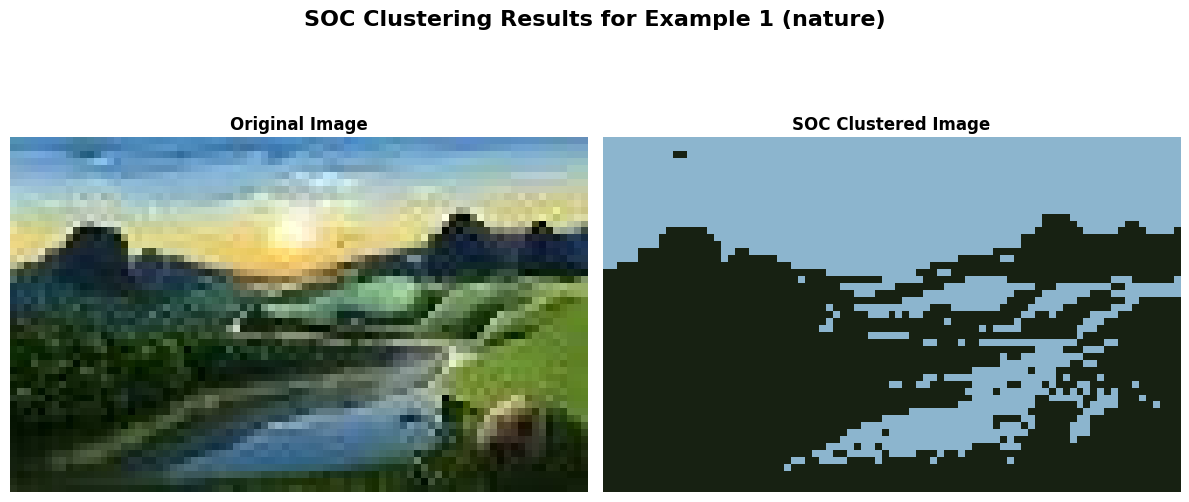


Results for Example 1 (nature) (optimum clusters = 2)
------------------------------------------------------
Method       |      GSI |         PI |         SI |       DI
------------------------------------------------------------------
IMC-1        |   0.6115 |     0.0299 |     0.7546 |   0.7766
IMC-2        |   0.6093 |     0.0314 |     0.7244 |   0.7516
IMC-max      |   0.6145 |     0.0260 |     0.7808 |   0.8276
IMC-half     |   0.6122 |     0.0268 |     0.8263 |   0.7806
SOC          |   0.6105 |     0.0310 |     0.7352 |   0.7624
K-means      |   0.6142 |     0.0303 |     0.9723 |   0.8126
FCM          |   0.6141 |     0.0285 |     0.9296 |   0.8125
EM           |   0.5593 |     0.0325 |     1.0105 |   0.5964
K-medoid     |   0.6137 |     0.0282 |     0.9094 |   0.7828
------------------------------------------------------------------


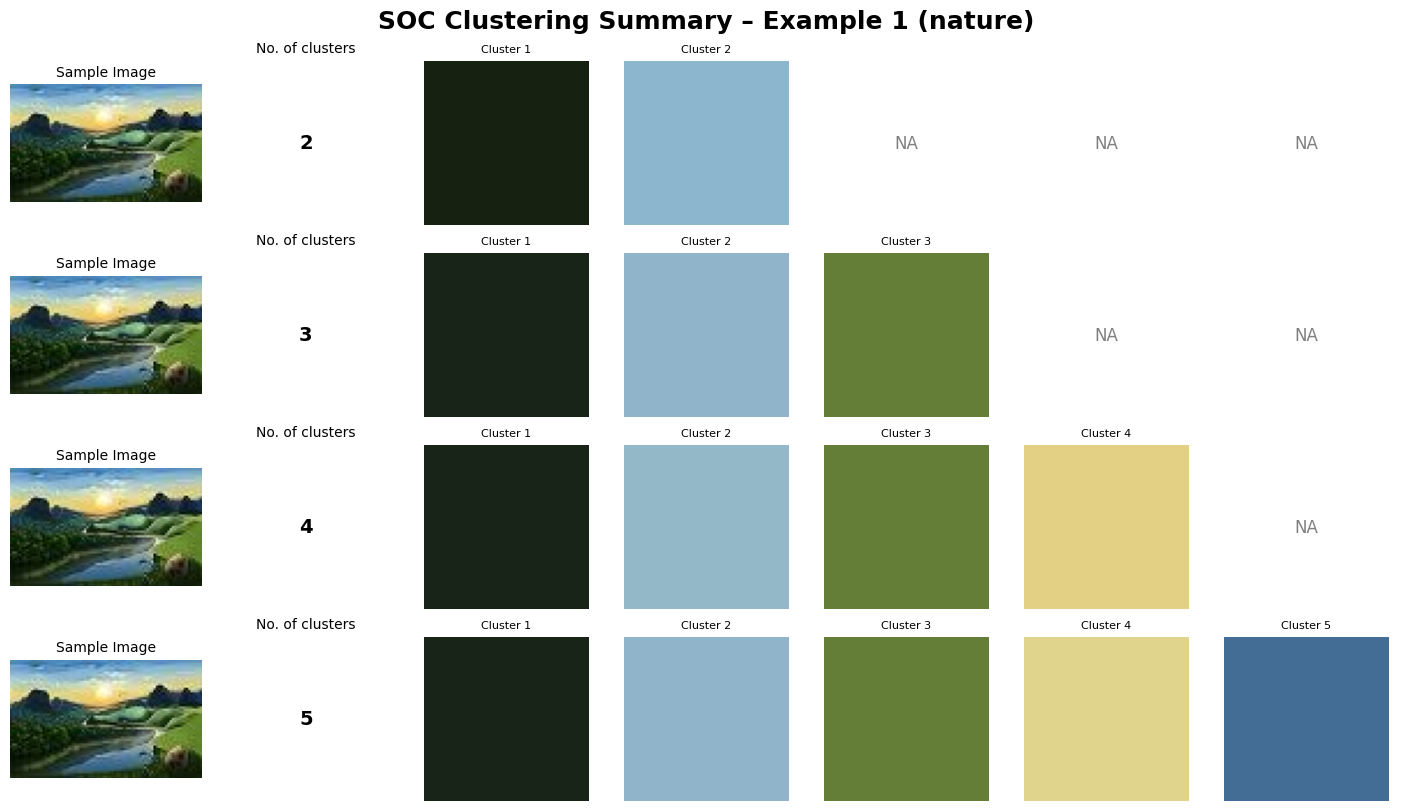

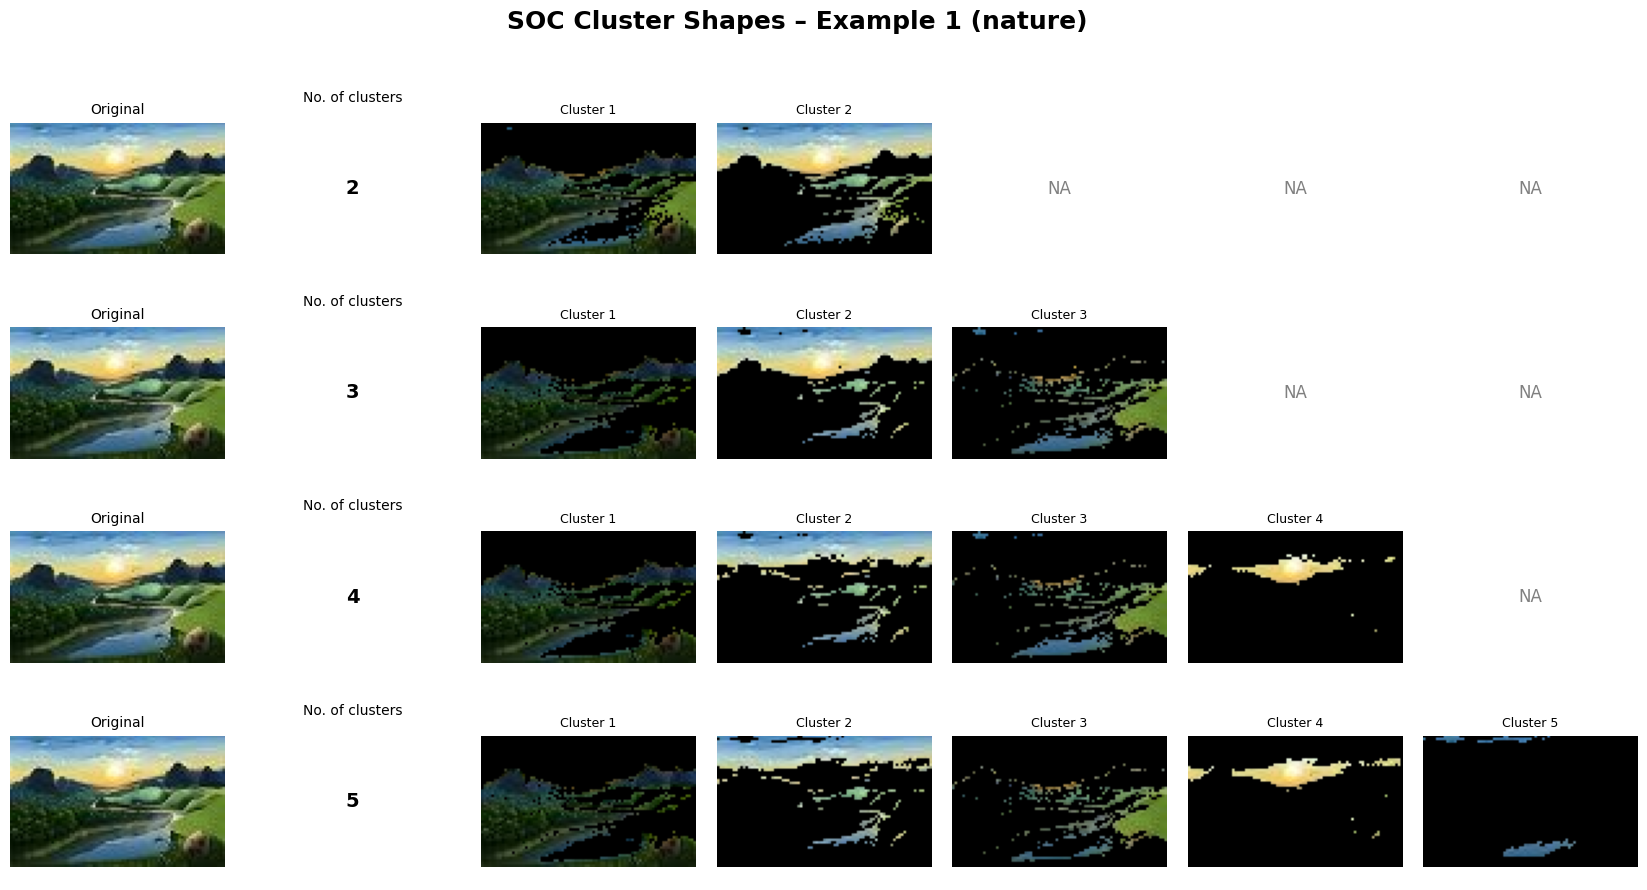

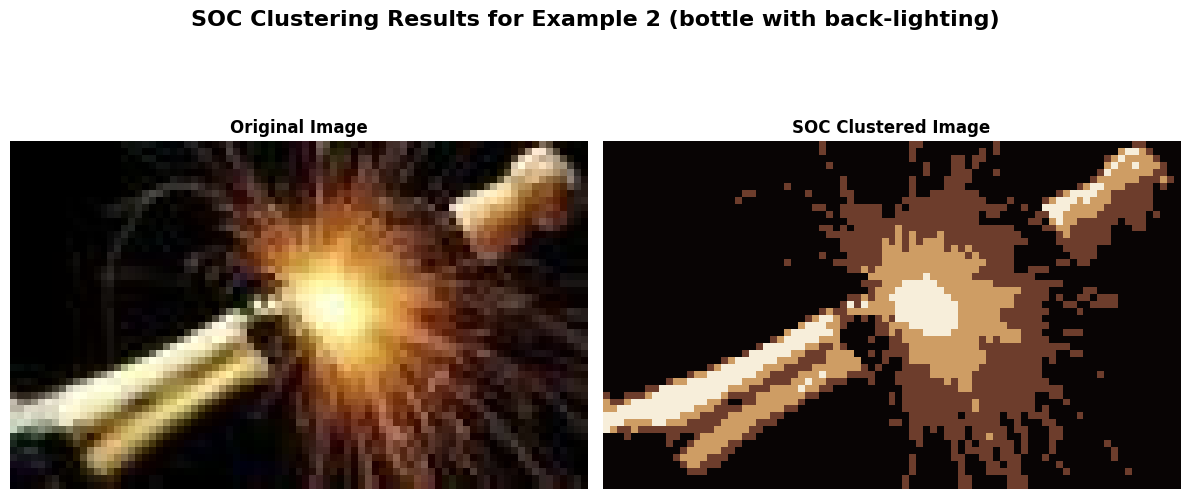


Results for Example 2 (bottle with back-lighting) (optimum clusters = 4)
-------------------------------------------------------------------------
Method       |      GSI |         PI |         SI |       DI
------------------------------------------------------------------
IMC-1        |   0.5967 |     0.0012 |    14.8397 |   0.6234
IMC-2        |   0.5858 |     0.0014 |    19.5140 |   0.5062
IMC-max      |   0.6461 |     0.0038 |     3.9410 |   0.9106
IMC-half     |   0.6396 |     0.0036 |     4.6814 |   0.7528
SOC          |   0.6040 |     0.0012 |    10.7790 |   0.7226
K-means      |   0.5894 |     0.0013 |    16.7226 |   0.4898
FCM          |   0.5890 |     0.0012 |    16.8752 |   0.5048
EM           |   0.2242 |     0.0022 |   191.9224 |   0.0648
K-medoid     |   0.5560 |     0.0015 |    24.3079 |   0.3113
------------------------------------------------------------------


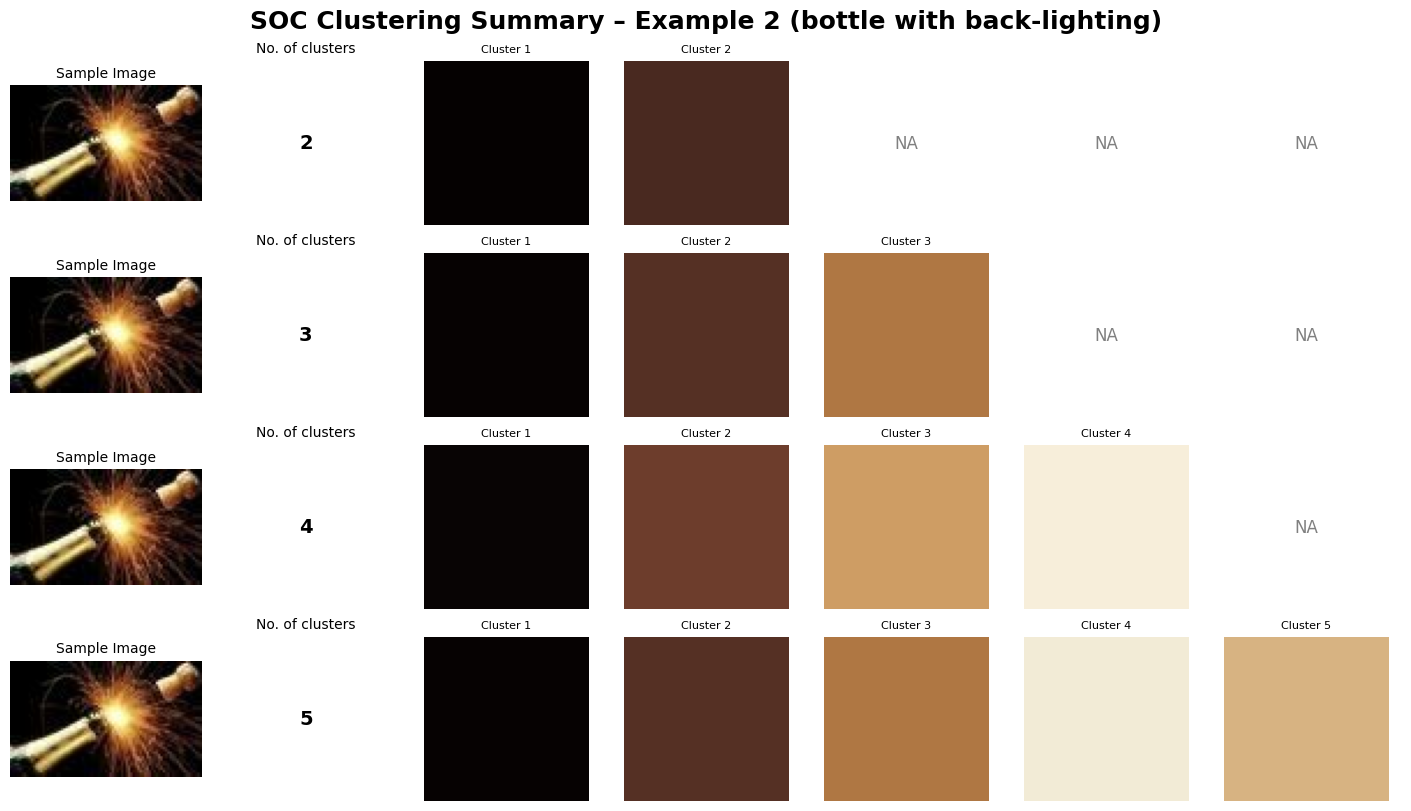

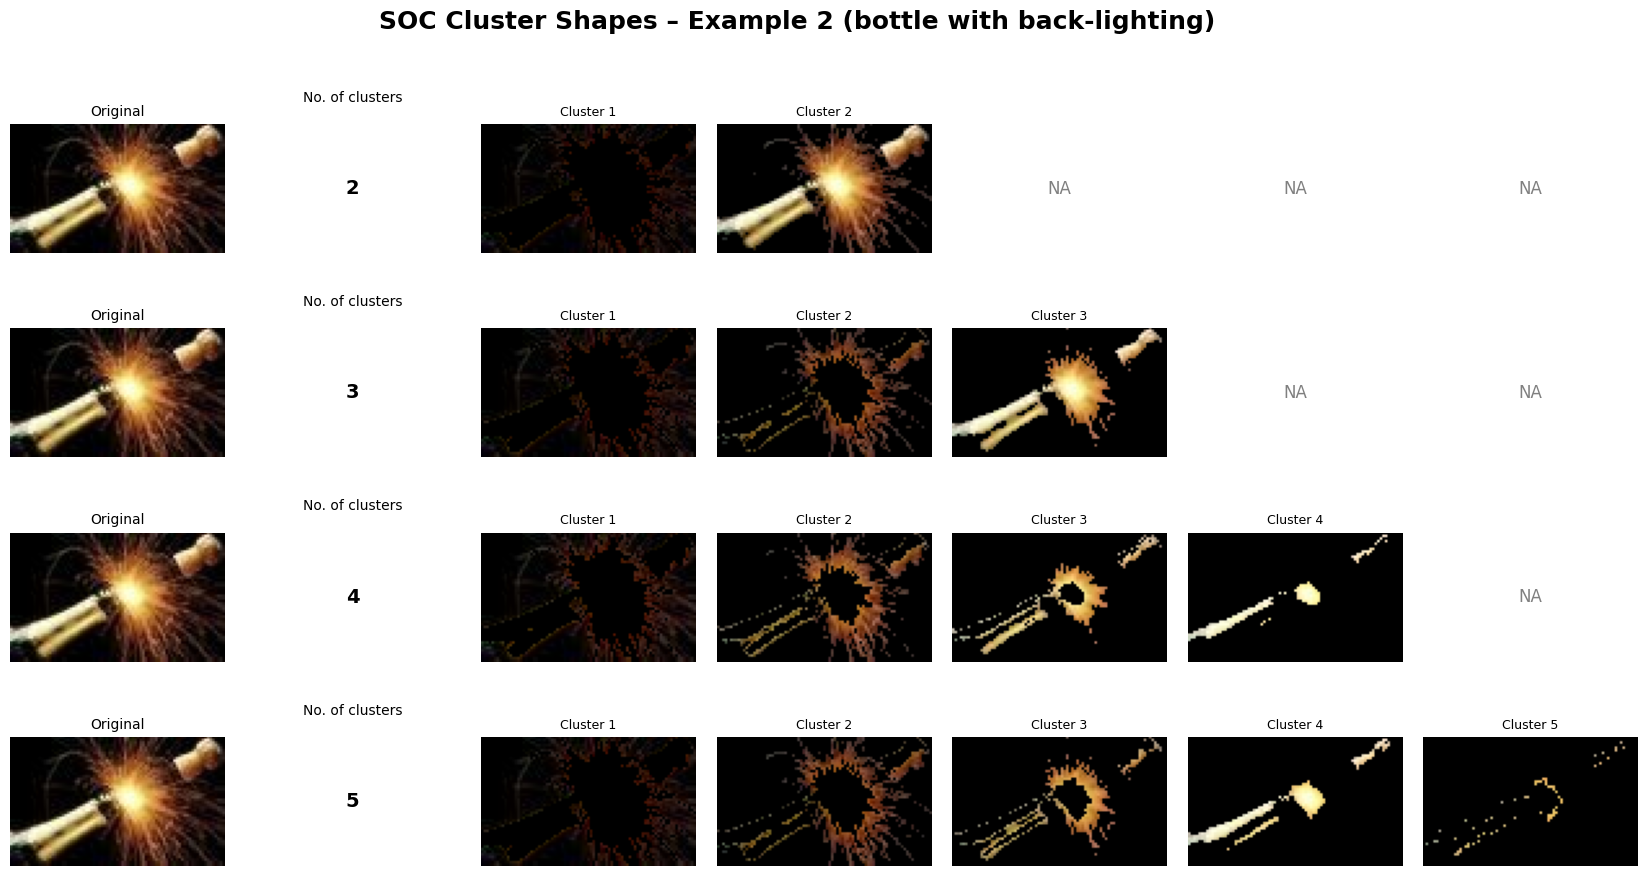

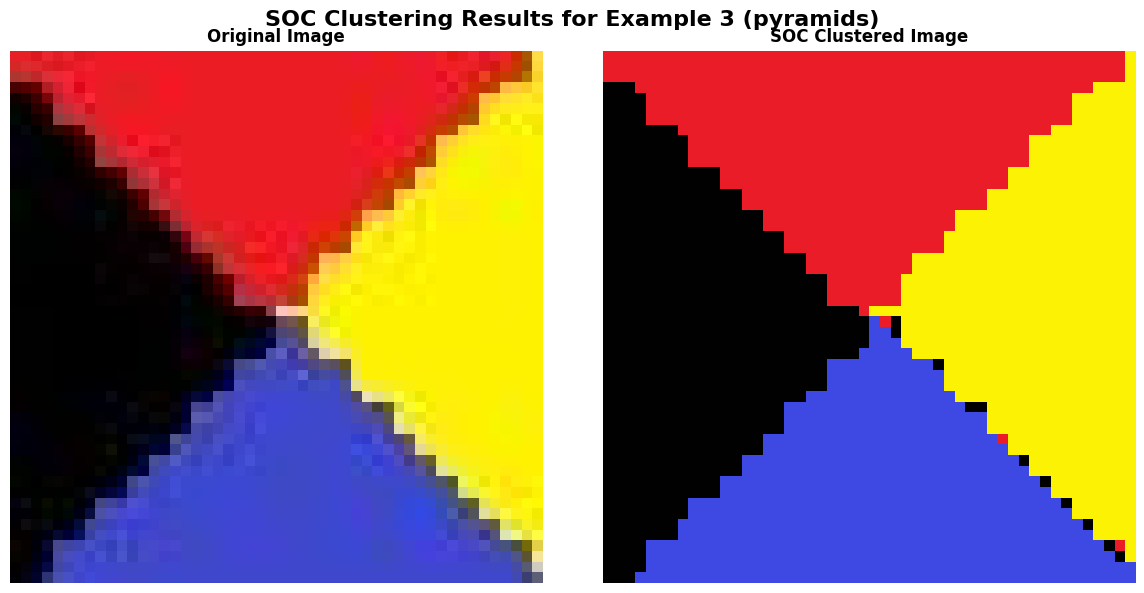


Results for Example 3 (pyramids) (optimum clusters = 4)
--------------------------------------------------------
Method       |      GSI |         PI |         SI |       DI
------------------------------------------------------------------
IMC-1        |   0.8548 |     0.0009 |     4.3777 |   0.8701
IMC-2        |   0.8548 |     0.0009 |     4.3892 |   0.8699
IMC-max      |   0.8535 |     0.0008 |     4.5026 |   0.9281
IMC-half     |   0.8548 |     0.0009 |     4.3712 |   0.8701
SOC          |   0.8548 |     0.0009 |     4.3838 |   0.8701
K-means      |   0.8547 |     0.0011 |     4.4570 |   0.9258
FCM          |   0.8547 |     0.0010 |     4.4457 |   0.9261
EM           |   0.8533 |     0.0011 |     4.4520 |   0.9092
K-medoid     |   0.8547 |     0.0010 |     4.3082 |   0.8703
------------------------------------------------------------------


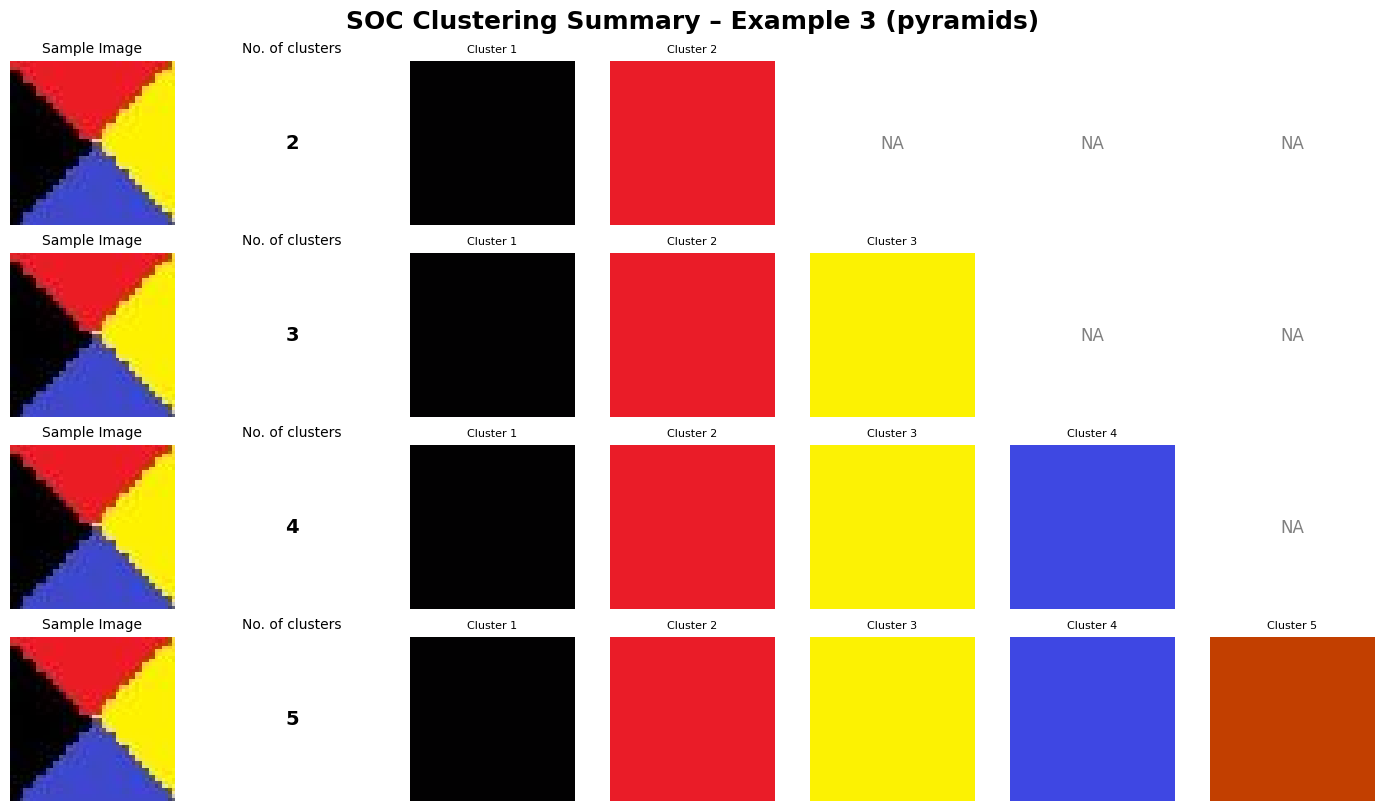

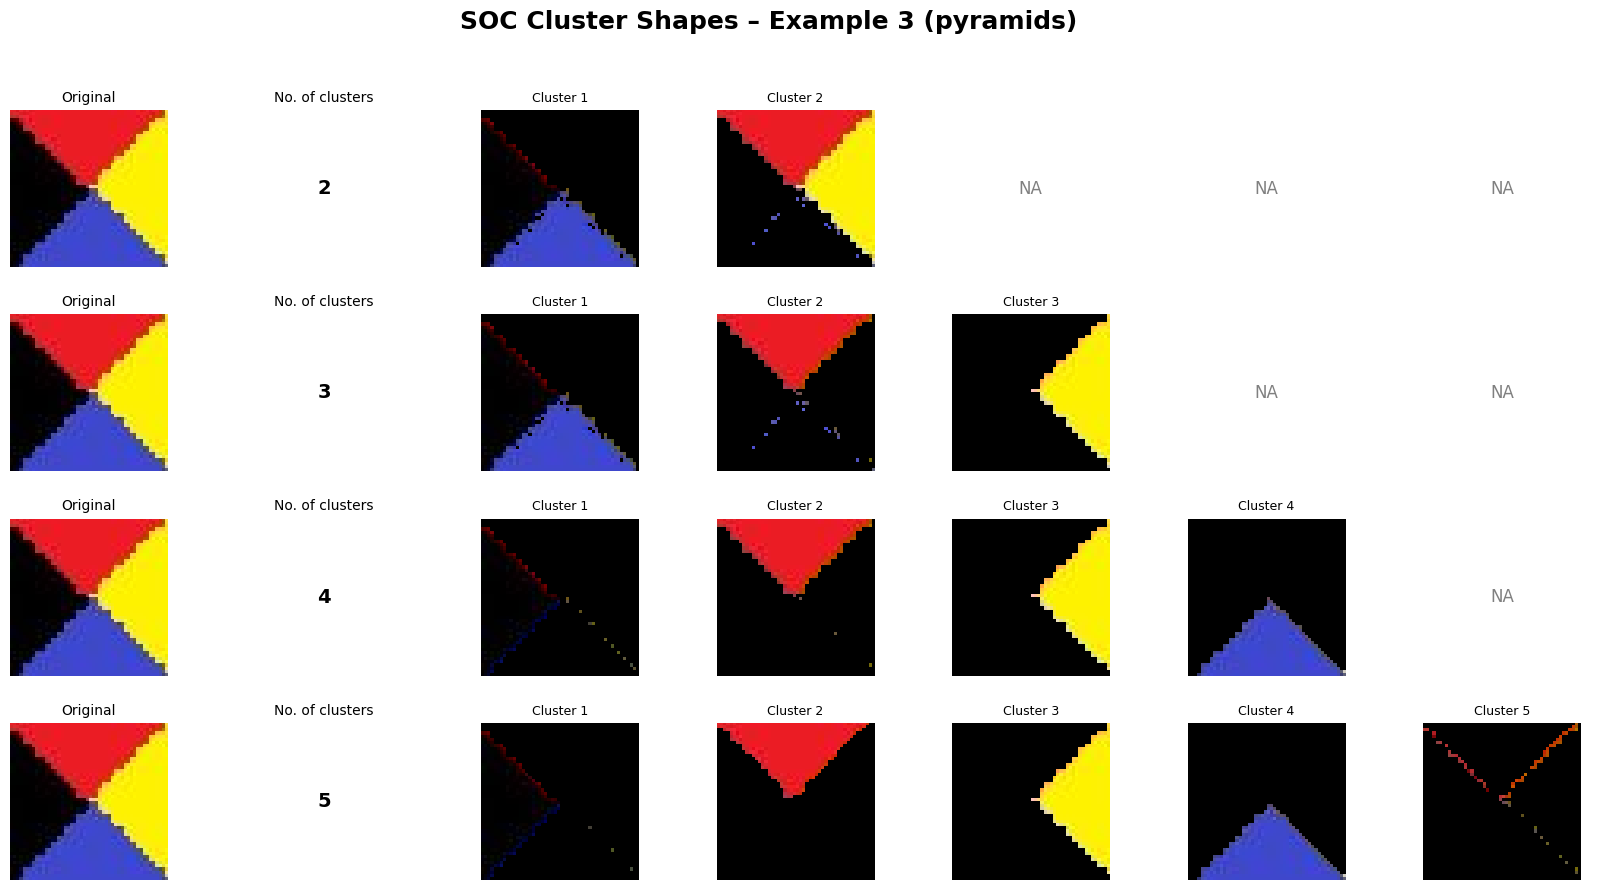

In [29]:
if __name__ == "__main__":
    demo_files = [
        ("/kaggle/input/soc-sample-images/nature.jpeg", "Example 1 (nature)"),
        ("/kaggle/input/soc-sample-images/bottle.jpeg", "Example 2 (bottle with back-lighting)"),
        ("/kaggle/input/soc-sample-images/fourcolor.jpeg", "Example 3 (pyramids)"),
    ]

    for fname, pretty in demo_files:
        if not os.path.isfile(fname):
            print(f"File '{fname}' not found – skip '{pretty}'.")
            continue
        img = img_as_float64(io.imread(fname))[..., :3]
        res = evaluate_image(img, pretty)
        print_table(res)
        make_soc_summary_table(img, pretty)
        plot_cluster_shapes_table(img, pretty)